# Cap√≠tulo 6 ‚Äì Detecci√≥n de Anomal√≠as con Isolation Forest

En este cap√≠tulo se presenta el algoritmo **Isolation Forest**, una t√©cnica no supervisada de detecci√≥n de anomal√≠as fundamentada en principios estad√≠sticos y estructurales.  
Su principal fortaleza radica en que no requiere datos etiquetados ni un entrenamiento supervisado, lo que lo convierte en una opci√≥n id√≥nea en contextos como el presente, donde no se dispone de informaci√≥n fiable que distinga entre observaciones normales y an√≥malas.

Isolation Forest se basa en la idea de que los puntos an√≥malos, al estar menos integrados en la distribuci√≥n general de los datos, pueden **aislarse m√°s f√°cilmente** a trav√©s de divisiones aleatorias del espacio de caracter√≠sticas.

## ¬øPor qu√© Isolation Forest?

Las razones para emplear Isolation Forest en detecci√≥n de anomal√≠as incluyen:

- Modelo ligero, interpretable y r√°pido de entrenar, adecuado para exploraci√≥n temprana.  
- No necesita etiquetas ni conocimiento experto previo.  
- Se aplica directamente sobre datos multivariantes sin grandes transformaciones.  
- Ha sido validado en m√∫ltiples entornos industriales, lo que respalda su aplicabilidad pr√°ctica.

## Intuici√≥n

Isolation Forest parte de la premisa:

> "Las anomal√≠as son m√°s f√°ciles de aislar que los puntos normales."

Mientras otros m√©todos buscan perfilar lo normal, iForest genera particiones aleatorias y mide lo f√°cil que resulta separar cada observaci√≥n.  
Las anomal√≠as, por su rareza y diferencias, requieren menos divisiones para quedar aisladas.

## Fundamento Te√≥rico

El algoritmo construye m√∫ltiples **√°rboles binarios aleatorios** (*iTrees*):

- En cada nodo se selecciona aleatoriamente:
  - Una caracter√≠stica.
  - Un valor de corte dentro de su rango.
- El √°rbol se construye recursivamente hasta aislar un √∫nico punto o alcanzar una profundidad m√°xima.

### Profundidad de aislamiento

Cada observaci√≥n recorre todos los √°rboles. La medida clave es la **profundidad media** necesaria para aislarla.  

- Anomal√≠as ‚Üí caminos cortos.  
- Normales ‚Üí caminos m√°s largos.  

El score de anomal√≠a se define como:

$$
s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
$$

donde $E(h(x))$ es la profundidad media y $c(n)$ el valor esperado de la profundidad en un √°rbol con $n$ puntos.

### Interpretaci√≥n del score

| Score $s(x)$ | Interpretaci√≥n                |
|--------------|-------------------------------|
| ‚âà 1          | Alta probabilidad de anomal√≠a |
| ‚âà 0.5        | Indefinido                    |
| ‚âà 0          | Punto normal                  |

## Par√°metros clave

- **n_estimators**: n√∫mero de √°rboles (t√≠pico: 100‚Äì256).  
- **max_samples**: n√∫mero de muestras para construir cada √°rbol.  
- **max_depth**: profundidad m√°xima del √°rbol.  
- **contamination**: fracci√≥n estimada de anomal√≠as (en implementaciones pr√°cticas).

## Ventajas

- Escalable a datasets grandes y de alta dimensi√≥n.  
- No depende de supuestos estad√≠sticos.  
- No supervisado, apto para entornos sin etiquetas.

## Limitaciones

- Sensible a la elecci√≥n de `max_samples`.  
- No captura relaciones temporales sin ingenier√≠a de caracter√≠sticas.  
- Puede no detectar anomal√≠as que consisten en **rupturas de relaciones entre variables** si estas combinaciones no son estad√≠sticamente infrecuentes.

### Ejemplo ilustrativo

En un motor en condiciones normales:  
- A bajas RPM (‚âà100), la temperatura del refrigerante deber√≠a ser baja (‚âà40 ¬∞C).  

Si aparece un punto con:  
- RPM = 100  
- Temperatura = 95 ¬∞C  

aunque viole la l√≥gica f√≠sica, el algoritmo puede no marcarlo como an√≥malo si existen otros puntos similares en los datos.


## Implementaci√≥n de un detector con Isolation Forest

Isolation Forest se implementa a partir de la idea de que las anomal√≠as se a√≠slan con menos particiones.  
El modelo se construye mediante m√∫ltiples √°rboles aleatorios (*iTrees*), y el score de anomal√≠a se calcula a partir de la profundidad media necesaria para aislar cada punto.

A continuaci√≥n se muestran las piezas fundamentales de la implementaci√≥n: funciones auxiliares, la definici√≥n del √°rbol base y finalmente la clase `IsolationForest` como detector.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from modelos.datasets_to_parquet import load_project_parquets
from modelos.base import BaseAnomalyDetector

def harmonic_number(n):
    if n <= 1:
        return 0
    return np.log(n) + 0.5772156649

def c_factor(n):
    if n <= 1:
        return 0
    return 2 * harmonic_number(n - 1) - (2 * (n - 1) / n)

#### Comprobaci√≥n r√°pida

A continuaci√≥n se representan \( H(n) \) y \( c(n) \) para distintos tama√±os de muestra.  
Esperamos crecimiento **logar√≠tmico suave**, √∫til como normalizador del score.


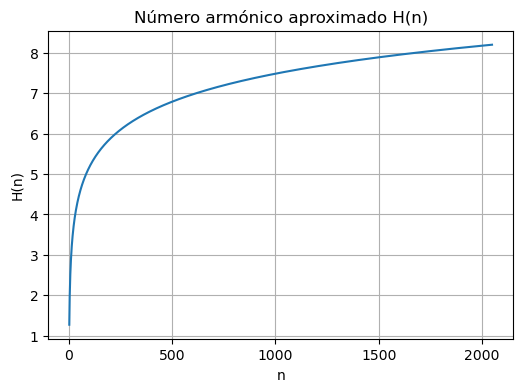

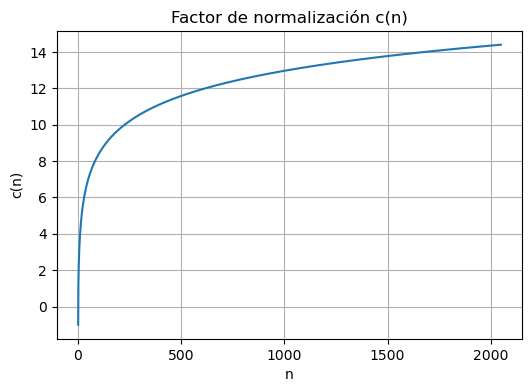

n	H(n)		c(n)
4	1.963510	1.851656
8	2.656657	3.296252
16	3.349804	4.695532
32	4.042952	6.084906
64	4.736099	7.471951
128	5.429246	8.858431
256	6.122393	10.244771
512	6.815540	11.631077
1024	7.508687	13.017374


In [3]:
# Rango de n para visualizar el crecimiento
ns = np.arange(2, 2049)  # desde 2 hasta 2048
H = np.array([harmonic_number(int(n)) for n in ns])
c = np.array([c_factor(int(n)) for n in ns])

# Gr√°fico 1: H(n)
plt.figure(figsize=(6, 4))
plt.plot(ns, H)
plt.xlabel("n")
plt.ylabel("H(n)")
plt.title("N√∫mero arm√≥nico aproximado H(n)")
plt.grid(True)
plt.show()

# Gr√°fico 2: c(n)
plt.figure(figsize=(6, 4))
plt.plot(ns, c)
plt.xlabel("n")
plt.ylabel("c(n)")
plt.title("Factor de normalizaci√≥n c(n)")
plt.grid(True)
plt.show()

# Tabla de referencia para n t√≠picos de sample_size
ns_ref = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
rows = [(n, harmonic_number(n), c_factor(n)) for n in ns_ref]

print("n\tH(n)\t\tc(n)")
for n, h, cf in rows:
    print(f"{n}\t{h:.6f}\t{cf:.6f}")


**Lectura de las figuras**

- Tanto \( H(n) \) como \( c(n) \) muestran un **crecimiento logar√≠tmico**.  
- Esto significa que:
  - **Al inicio** (para valores peque√±os de \( n \)) el incremento es muy r√°pido.  
  - **Despu√©s**, conforme \( n \) crece, el aumento se vuelve cada vez m√°s lento y las curvas se van ‚Äúaplanando‚Äù.  
- Gracias a este comportamiento, la **profundidad esperada de los √°rboles en Isolation Forest** no crece sin control con el tama√±o de los datos, sino de manera moderada.  
- En la pr√°ctica, esto evita que el score de anomal√≠a dependa directamente del tama√±o del dataset y permite comparar resultados entre distintas configuraciones.



### √Årbol de aislamiento (`iTree`)

Un `iTree` se construye recursivamente:
- En cada nodo se elige **una caracter√≠stica** al azar y un **valor de corte**.
- Se divide el conjunto en izquierda/derecha y se sigue recursivamente.
- Paramos si alcanzamos una **profundidad m√°xima** o si hay **‚â§ 1 muestra**.

En la implementaci√≥n original de *Isolation Forest*, el corte se hace **uniformemente al azar** en el intervalo `[min, max]` de la caracter√≠stica elegida.  

En esta versi√≥n a√±adimos una **variante**: el corte se puede escoger como un valor aleatorio de entre los **valores reales de la muestra**.  
Esto introduce un cierto sesgo hacia zonas m√°s densas de la distribuci√≥n (una estimaci√≥n muy simple de la densidad).


In [4]:
class iTree:
    def __init__(self, data, current_height=0, max_height=np.inf, split_selection_random=True):
        self.n_samples, self.n_features = data.shape
        self.left = None
        self.right = None
        self.split_attr = None
        self.split_value = None
        self.size = self.n_samples
        self.is_leaf = False

        # Criterios de parada
        if current_height >= max_height or self.n_samples <= 1:
            self.is_leaf = True
            return

        # Elegimos una caracter√≠stica al azar
        self.split_attr = np.random.randint(self.n_features)
        # Rango de esa caracter√≠stica
        col = data[:, self.split_attr]
        min_val, max_val = np.min(col), np.max(col)

        # Si no hay variaci√≥n, hacemos hoja
        if min_val == max_val:
            self.is_leaf = True
            return

        # Valor de corte: uniforme en el rango o aleatorio entre valores observados
        if split_selection_random:
            self.split_value = float(np.random.uniform(min_val, max_val))
        else:
            self.split_value = float(np.random.choice(col))

        # Divisi√≥n
        left_mask = col < self.split_value
        self.left = iTree(data[left_mask], current_height + 1, max_height, split_selection_random)
        self.right = iTree(data[~left_mask], current_height + 1, max_height, split_selection_random)


#### Comprobaci√≥n r√°pida del nodo ra√≠z

Generamos un dataset sencillo en 2D y entrenamos dos √°rboles:
1. Con **split uniforme en el rango** (versi√≥n original).
2. Con **split tomado de la muestra** (variante a√±adida).

Visualizamos el corte en cada caso para ver c√≥mo cambia la partici√≥n.


Split uniforme:
 - Atributo: 0, Valor: 1.174
Split por muestra:
 - Atributo: 1, Valor: -1.567


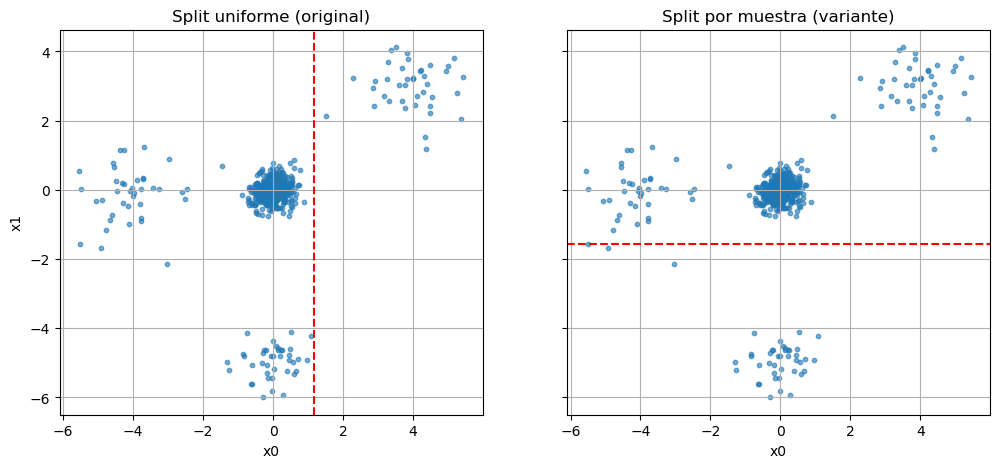

In [15]:
# Dataset 2D exagerado
rng = np.random.default_rng(42)

# Cl√∫ster muy denso en el centro
X_center = rng.normal(loc=[0, 0], scale=[0.3, 0.3], size=(400, 2))

# Algunos cl√∫steres dispersos m√°s alejados
X_out1 = rng.normal(loc=[-4, 0], scale=[0.8, 0.8], size=(40, 2))
X_out2 = rng.normal(loc=[4, 3], scale=[1.0, 0.5], size=(40, 2))
X_out3 = rng.normal(loc=[0, -5], scale=[0.6, 0.6], size=(40, 2))

# Concatenar todo
X_demo = np.vstack([X_center, X_out1, X_out2, X_out3])

# √Årbol con split uniforme
tree_uniform = iTree(X_demo, current_height=0, max_height=1, split_selection_random=True)

# √Årbol con split basado en muestra
tree_sample = iTree(X_demo, current_height=0, max_height=1, split_selection_random=False)

print("Split uniforme:")
print(f" - Atributo: {tree_uniform.split_attr}, Valor: {tree_uniform.split_value:.3f}")
print("Split por muestra:")
print(f" - Atributo: {tree_sample.split_attr}, Valor: {tree_sample.split_value:.3f}")

# Visualizaci√≥n
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, tree, title in zip(
    axes,
    [tree_uniform, tree_sample],
    ["Split uniforme (original)", "Split por muestra (variante)"]
):
    ax.scatter(X_demo[:,0], X_demo[:,1], s=10, alpha=0.6)
    if tree.split_attr == 0:
        ax.axvline(tree.split_value, ls="--", color="red")
    else:
        ax.axhline(tree.split_value, ls="--", color="red")
    ax.set_title(title)
    ax.set_xlabel("x0"); ax.grid(True)
axes[0].set_ylabel("x1")
plt.show()


**Lectura r√°pida**

- El **split uniforme** tiende a cortar en cualquier parte del rango, incluso en zonas donde apenas hay datos.  
- El **split basado en la muestra** coloca el corte en valores que realmente aparecen en los datos, lo que hace que la partici√≥n est√© m√°s alineada con la densidad observada, m√°s amenudo.  

Esta variante no est√° en el algoritmo original, pero puede hacer que los √°rboles se ajusten un poco m√°s a la distribuci√≥n real.


#### Profundidad de camino (`path_length`)

Para evaluar lo ‚Äúf√°cil‚Äù que es aislar un punto, calculamos la **longitud del camino** que recorre desde la ra√≠z hasta que:
- llega a una **hoja**, y
- a√±adimos la **correcci√≥n** por el tama√±o de la hoja con \( c(\text{size}) \) para ajustar la expectativa.

Implementamos `path_length` y lo probamos coloreando los puntos por su longitud de camino en un √°rbol poco profundo.


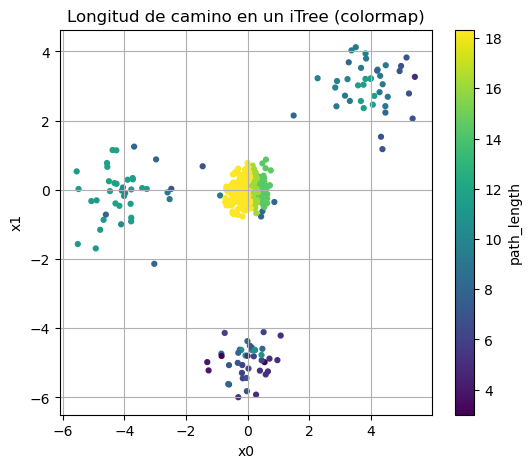

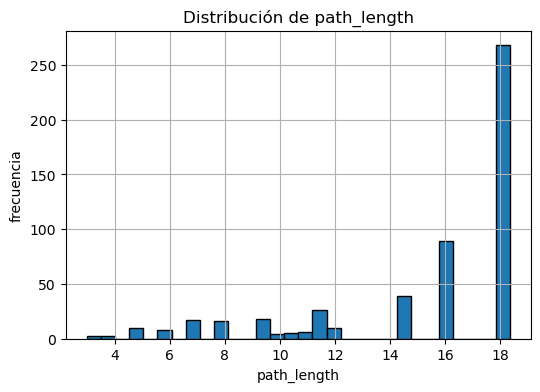

In [16]:
# A√±adimos el m√©todo a la clase.
def _path_length(self, x, current_height=0):
    if self.is_leaf:
        return current_height + c_factor(self.size)
    if x[self.split_attr] < self.split_value:
        return self.left.path_length(x, current_height + 1)
    else:
        return self.right.path_length(x, current_height + 1)

setattr(iTree, "path_length", _path_length)

# Construimos un √°rbol con mayor profundidad para ver m√°s variedad
tree_demo2 = iTree(X_demo, current_height=0, max_height=8, split_selection_random=True)

# Longitud de camino por punto
pl = np.array([tree_demo2.path_length(x) for x in X_demo])

# Visualizaci√≥n: puntos coloreados por longitud de camino
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(X_demo[:,0], X_demo[:,1], c=pl, s=12)
ax.set_title("Longitud de camino en un iTree (colormap)")
ax.set_xlabel("x0"); ax.set_ylabel("x1"); ax.grid(True)
cb = plt.colorbar(sc, ax=ax); cb.set_label("path_length")
plt.show()

# Tambi√©n un histograma para ver la distribuci√≥n
plt.figure(figsize=(6, 4))
plt.hist(pl, bins=30, edgecolor="k")
plt.title("Distribuci√≥n de path_length"); plt.xlabel("path_length"); plt.ylabel("frecuencia")
plt.grid(True); plt.show()


**Lectura r√°pida**
- Puntos cercanos a regiones separables suelen requerir **menos splits** ‚Üí menor `path_length`.
- Puntos integrados en zonas densas necesitan **m√°s splits** ‚Üí mayor `path_length`.
- Esta medida, normalizada por \( c(n) \) en el bosque, se transformar√° despu√©s en un **score de anomal√≠a**.


## Implementaci√≥n del detector Isolation Forest

`IsolationForest` ensambla m√∫ltiples `iTree` entrenados sobre **submuestras aleatorias** del conjunto de datos.  
Incorpora dos ideas clave:

- **Profundidad m√°xima** del √°rbol proporcional a `log2(sample_size)`, lo que controla el crecimiento.
- **Pol√≠tica de umbral**:
  - Si `contamination` es `None` ‚Üí umbral fijo `œÑ = 0.5` (criterio cl√°sico del score).
  - Si `contamination ‚àà (0,1]` ‚Üí umbral aprendido como el cuantil `1 - contamination` de los *scores* en entrenamiento.

Adem√°s, hereda la **pol√≠tica de corte** del `iTree`:
- `split_selection_random=True`: corte uniforme en `[min, max]` (original).
- `split_selection_random=False`: corte tomado de valores de la muestra (variante con sesgo hacia zonas densas).


In [17]:
import numpy as np
from modelos.base import BaseAnomalyDetector  # ya definida en el notebook anterior

class IsolationForest(BaseAnomalyDetector):
    """
    Detector Isolation Forest con dos pol√≠ticas de split en cada nodo:
      - split_selection_random=True  -> corte uniforme en [min, max] (original)
      - split_selection_random=False -> corte elegido de la muestra (variante densa)

    Pol√≠tica de umbral:
      - contamination is None  -> œÑ = 0.5 (fijo)
      - contamination in (0,1] -> œÑ = quantile_{1-cont}(scores_train)
    """
    def __init__(self,
                 n_trees: int = 100,
                 sample_size: int = 256,
                 split_selection_random: bool = True,
                 contamination: float | None = None):
        self.n_trees = int(n_trees)
        self.sample_size = int(sample_size)
        self.split_selection_random = bool(split_selection_random)
        self.contamination = contamination  # None => œÑ=0.5 ; (0,1] => cuantil
        self.trees = []
        self.threshold_ = None  # se fijar√° en fit()

    # Dummy fit: solo guarda los datos
    def fit(self, X):
        X = np.asarray(X)
        self.trees = []          # en la versi√≥n real ir√≠an los √°rboles
        self.threshold_ = 0.5    # valor fijo por ahora
        return self

    # Dummy anomaly_score: devuelve ceros
    def anomaly_score(self, X):
        X = np.asarray(X)
        return np.zeros(len(X))

    # Dummy predict: compara scores con threshold_
    def predict(self, X):
        scores = self.anomaly_score(X)
        return (scores >= (self.threshold_ or 0.5)).astype(int)

### M√©todo `fit`

Durante el ajuste:
1. Se calcula la **profundidad m√°xima** del √°rbol como `ceil(log2(max(sample_size, 2)))`.
2. Para cada uno de los `n_trees`:
   - Se extrae una **submuestra aleatoria** de tama√±o `sample_size` (sin reemplazo si es menor que `n`, con reemplazo en caso contrario).
   - Se construye un `iTree` con la pol√≠tica de split elegida.
3. Se fija el **umbral de decisi√≥n** `œÑ`:
   - `œÑ = 0.5` si `contamination is None`.
   - `œÑ = quantile_{1-cont}(scores_train)` si se proporciona `contamination`.

In [18]:
def _fit(self, X):
    X = np.asarray(X)
    self.trees = []
    n = len(X)

    # Profundidad m√°xima ~ log2(sample_size)
    height_limit = int(np.ceil(np.log2(max(self.sample_size, 2))))

    # Construcci√≥n del bosque
    for _ in range(self.n_trees):
        if self.sample_size < n:
            idx = np.random.choice(n, self.sample_size, replace=False)
        else:
            idx = np.random.choice(n, self.sample_size, replace=True)
        sample = X[idx]
        tree = iTree(sample,
                        current_height=0,
                        max_height=height_limit,
                        split_selection_random=self.split_selection_random)
        self.trees.append(tree)

    # Pol√≠tica de umbral
    if self.contamination is None:
        self.threshold_ = 0.5
    else:
        scores_train = self.anomaly_score(X)
        q = float(1.0 - self.contamination)
        q = min(max(q, 0.0), 1.0)  # seguridad
        self.threshold_ = np.quantile(scores_train, q)
    return self

setattr(IsolationForest, "fit", _fit)


#### Comprobaci√≥n de `fit` con datos de juguete

Usamos el dataset 2D exagerado de antes para entrenar r√°pidamente y ver:
- N√∫mero de √°rboles construidos.
- Profundidad m√°xima empleada.
- Umbral resultante.

In [19]:
# Reutilizamos X_demo creado anteriormente (cl√∫ster central denso + grupos perif√©ricos)
forest = IsolationForest(n_trees=20, sample_size=128, split_selection_random=False)
forest.fit(X_demo)

print("√Årboles construidos:", len(forest.trees))
print("Umbral (threshold_):", f"{forest.threshold_:.4f}" if forest.threshold_ is not None else None)

# Podemos inferir la profundidad m√°xima a partir del primer √°rbol entrenado
# (no se almacena expl√≠citamente; la computamos de nuevo para mostrarla)
height_limit = int(np.ceil(np.log2(max(forest.sample_size, 2))))
print("Profundidad m√°xima (estimada):", height_limit)


√Årboles construidos: 20
Umbral (threshold_): 0.5000
Profundidad m√°xima (estimada): 7


### M√©todo `anomaly_score`

El **score de anomal√≠a** mide lo f√°cil que es aislar un punto:

$$
s(x) = 2^{-\frac{E(h(x))}{c(n)}}
$$

- $E(h(x))$: longitud media del camino hasta aislar $x$ en todos los √°rboles.
- $c(n)$: factor de normalizaci√≥n que ajusta la profundidad esperada en un √°rbol aleatorio de tama√±o $n$.

Interpretaci√≥n:
- **Valores cercanos a 1** ‚Üí puntos aislados r√°pidamente ‚Üí posibles anomal√≠as.
- **Valores bajos** ‚Üí puntos normales, requieren m√°s divisiones.


In [20]:
def _anomaly_score(self, X):
        X = np.asarray(X)
        scores = np.zeros(len(X), dtype=float)
        denom = c_factor(self.sample_size)
        if denom <= 0:
            denom = 1.0  # seguridad num√©rica
        for i, x in enumerate(X):
            path_lengths = np.array([t.path_length(x) for t in self.trees], dtype=float)
            E_h = np.mean(path_lengths)
            scores[i] = 2 ** (-E_h / denom)
        return scores

setattr(IsolationForest, "anomaly_score", _anomaly_score)

#### Visualizaci√≥n de los *scores*

Probamos el m√©todo con el dataset sint√©tico `X_demo`:
- Mostramos un histograma de los scores.
- Visualizamos en 2D coloreando cada punto seg√∫n su score de anomal√≠a.


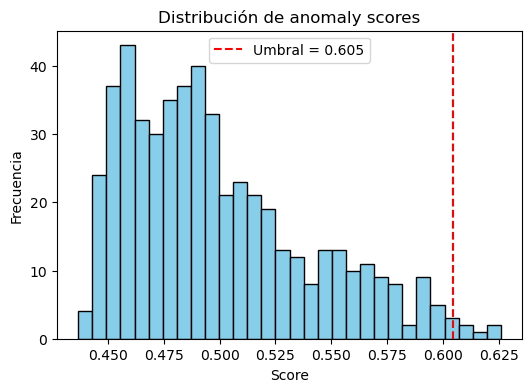

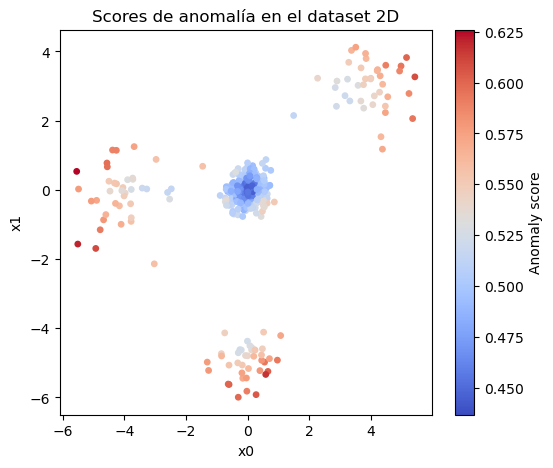

In [21]:
# Entrenamos de nuevo el bosque sobre X_demo
forest = IsolationForest(n_trees=50, sample_size=128, split_selection_random=False, contamination=0.01)
forest.fit(X_demo)

# Calculamos los scores
scores = forest.anomaly_score(X_demo)

# Histograma de scores
plt.figure(figsize=(6,4))
plt.hist(scores, bins=30, color="skyblue", edgecolor="black")
plt.axvline(forest.threshold_, color="red", linestyle="--", label=f"Umbral = {forest.threshold_:.3f}")
plt.title("Distribuci√≥n de anomaly scores")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# Scatter plot coloreado por score
plt.figure(figsize=(6,5))
plt.scatter(X_demo[:,0], X_demo[:,1], c=scores, cmap="coolwarm", s=15)
plt.colorbar(label="Anomaly score")
plt.title("Scores de anomal√≠a en el dataset 2D")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()


### M√©todo `predict`

El m√©todo `predict` transforma los *scores* en etiquetas binarias:
- **1 = anomal√≠a** si el score ‚â• umbral.
- **0 = normal** en caso contrario.

El umbral `œÑ` puede fijarse de dos formas:
- Autom√°ticamente en `fit()` (dependiendo de `contamination`).
- Manualmente pasando un valor al argumento `threshold` de `predict`.


In [22]:
def _predict(self, X, threshold=None):
        X = np.asarray(X)
        tau = threshold if threshold is not None else self.threshold_
        return (self.anomaly_score(X) >= tau).astype(int)

setattr(IsolationForest, "predict", _predict)

#### Predicciones en el dataset sint√©tico

Aplicamos `predict` a `X_demo` y visualizamos:
- Los puntos normales frente a los detectados como an√≥malos.

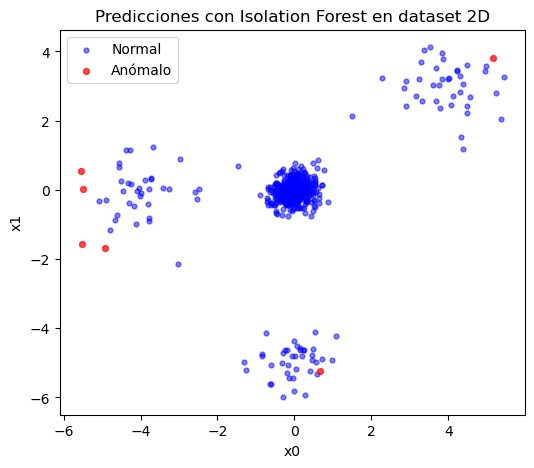

In [23]:
forest = IsolationForest(n_trees=50, sample_size=128, split_selection_random=False, contamination=0.01)
forest.fit(X_demo)

y_pred = forest.predict(X_demo)

# Scatter mostrando normales vs anomal√≠as
plt.figure(figsize=(6,5))
plt.scatter(X_demo[y_pred==0,0], X_demo[y_pred==0,1], c="blue", s=12, alpha=0.5, label="Normal")
plt.scatter(X_demo[y_pred==1,0], X_demo[y_pred==1,1], c="red", s=18, alpha=0.7, label="An√≥malo")
plt.title("Predicciones con Isolation Forest en dataset 2D")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()
plt.show()

## Conclusi√≥n

Isolation Forest nos muestra que, a veces, **la simplicidad es el mejor aliado** en la detecci√≥n de anomal√≠as.  
Basado √∫nicamente en aislar puntos de forma aleatoria, consigue un equilibrio interesante entre eficiencia, interpretabilidad y capacidad de generalizaci√≥n.  

No obstante, su car√°cter aleatorio y la ausencia de un modelado expl√≠cito de la frontera entre lo normal y lo an√≥malo hacen que, en ciertos escenarios, pueda resultar insuficiente.  
Precisamente por ello, en el pr√≥ximo cap√≠tulo exploraremos un enfoque de naturaleza distinta: **One-Class SVM**, un modelo que, en lugar de buscar el aislamiento, se centra en **aprender la frontera del espacio normal** y detectar las observaciones que se desv√≠an de ella.  

Este contraste entre t√©cnicas complementarias enriquecer√° nuestra visi√≥n sobre c√≥mo abordar el problema de la detecci√≥n de anomal√≠as desde diferentes √°ngulos.


---

## Referencias

- Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou.  
**"Isolation forest."** *2008 Eighth IEEE International Conference on Data Mining*. IEEE, 2008.  

- Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou.  
**"Isolation-based anomaly detection."** *ACM Transactions on Knowledge Discovery from Data (TKDD)* 6.1 (2012): 1‚Äì39.  

- Hariri, Sahar, Matias R. Carrasco Kind, and Robert J. Brunner.  
**"Extended isolation forest."** *IEEE Transactions on Knowledge and Data Engineering* 33.4 (2021): 1479‚Äì1489.  


Aqu√≠ empieza el experimento de un ISOLATION FOREST Brutalmente r√°pido:

Definir el grid de hiperpar√°metros

In [1]:
from modelos.IsolationForest import IsolationForest, IsolationForestCPU
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)

metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_coverage": window_coverage_metric,
}

param_grid = {
    "n_trees": [50, 100, 150, 200, 250],
    "sample_size": [64, 128, 256, 512, 1024],
    "contamination": [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15,],
    "split_selection_random": [False],
}


Iniciamos cluster de Dask en GPU y corremos experimento

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Cannot get CPU affinity")

from dask_cuda import LocalCUDACluster
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

print("Cluster Dask en CPU inicializado")
print(client)
# Dashboard: http://127.0.0.1:8787


from runner import run_dataset_experiment

df_results, topk, df_final = run_dataset_experiment(
    dataset_name="BATADAL",
    model_class=IsolationForestCPU,
    param_grid=param_grid,
    metrics=metrics,
    params_cv={"num_windows": 3},   # reduce al inicio para que vaya r√°pido
    device="cpu",
    mode="tscv",
    hampel_cfg={"window": 25, "sigma": 5.0},
    top_k=5,
    sort_metric="nab",
    plot_mode="best"
)



Cluster Dask en CPU inicializado
<Client: 'tcp://127.0.0.1:41043' processes=4 threads=16, memory=49.02 GiB>
üèÅ Ejecutando experimento en dataset: BATADAL
[‚úì] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/BATADAL/data.parquet (12938 filas)
   - Train: 8761 filas
   - Val:   2506 filas
   - Test:  1671 filas
Usando CPU (pandas + numpy) para este experimento.
